In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from collections import Counter, defaultdict
import json
import requests
import itertools

# Part 1

In [ ]:
categories_type = pd.read_json('categories.json', lines=True)
categories_mapping = {v[0]: k for k, v in categories_type.to_dict('list').items()}

In [ ]:
data = pd.read_json('train_gold.json', lines=True)
train_data, test_data = train_test_split(data, test_size=0.1, random_state=43)
train_data_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

## Number of samples that have N categories, for 1 <= N <= 6


In [ ]:
cat_len = [0 for _ in range(6)]
for cat_list in train_data['categories']:
  cat_len[len(cat_list)-1] += 1

for i in range(len(cat_len)):
  print('Occur {}: {}'.format(i+1, cat_len[i]))


Occur 1: 21048
Occur 2: 4922
Occur 3: 1509
Occur 4: 745
Occur 5: 348
Occur 6: 228


## Category distribution (how many times does each category appear)

In [ ]:
cat_count = Counter()
for cat_list in train_data['categories']:
  cat_count.update(cat_list)
print(cat_count) 

Counter({'applause': 3091, 'hug': 2925, 'agree': 2678, 'yes': 2459, 'no': 1971, 'seriously': 1802, 'facepalm': 1795, 'smh': 1698, 'sigh': 1599, 'shocked': 1519, 'omg': 1394, 'slow_clap': 1215, 'eye_roll': 1098, 'idk': 970, 'awww': 887, 'eww': 826, 'dance': 822, 'oh_snap': 800, 'ok': 784, 'shrug': 768, 'thank_you': 765, 'scared': 751, 'you_got_this': 742, 'oops': 735, 'happy_dance': 714, 'good_luck': 640, 'thumbs_up': 619, 'please': 548, 'popcorn': 527, 'wink': 517, 'high_five': 489, 'win': 424, 'yawn': 414, 'deal_with_it': 386, 'hearts': 305, 'sorry': 304, 'do_not_want': 301, 'fist_bump': 267, 'want': 261, 'thumbs_down': 196, 'yolo': 182, 'kiss': 165, 'mic_drop': 154})


## 10 most common pairs of co-occurring categories

In [ ]:
category_matrix = [[0 for _ in range(43)] for _ in range(43)]
for category_list in train_data['categories']:
    for combin in itertools.combinations(category_list, 2):
        category_matrix[categories_mapping[combin[0]]][categories_mapping[combin[1]]] += 1
        category_matrix[categories_mapping[combin[1]]][categories_mapping[combin[0]]] += 1

row_column_count = []
for i in range(43):
  for j in range(43):
    row_column_count.append((i, j, category_matrix[i][j]))

row_column_count.sort(key=lambda x:x[2], reverse=True)

count = 0
for i in range(len(row_column_count)):
  if count == 10:
    break
  if row_column_count[i][1] <= row_column_count[i][0]:
    for key, value in categories_mapping.items():
        if value == row_column_count[i][0]:
            print(key, end=' ')
    for key, value in categories_mapping.items():
        if value == row_column_count[i][1]:
            print(key)
    count += 1

seriously facepalm
slow_clap applause
yes agree
smh sigh
sigh facepalm
smh facepalm
sigh seriously
smh seriously
shocked omg
shrug idk


## Additional statistics

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


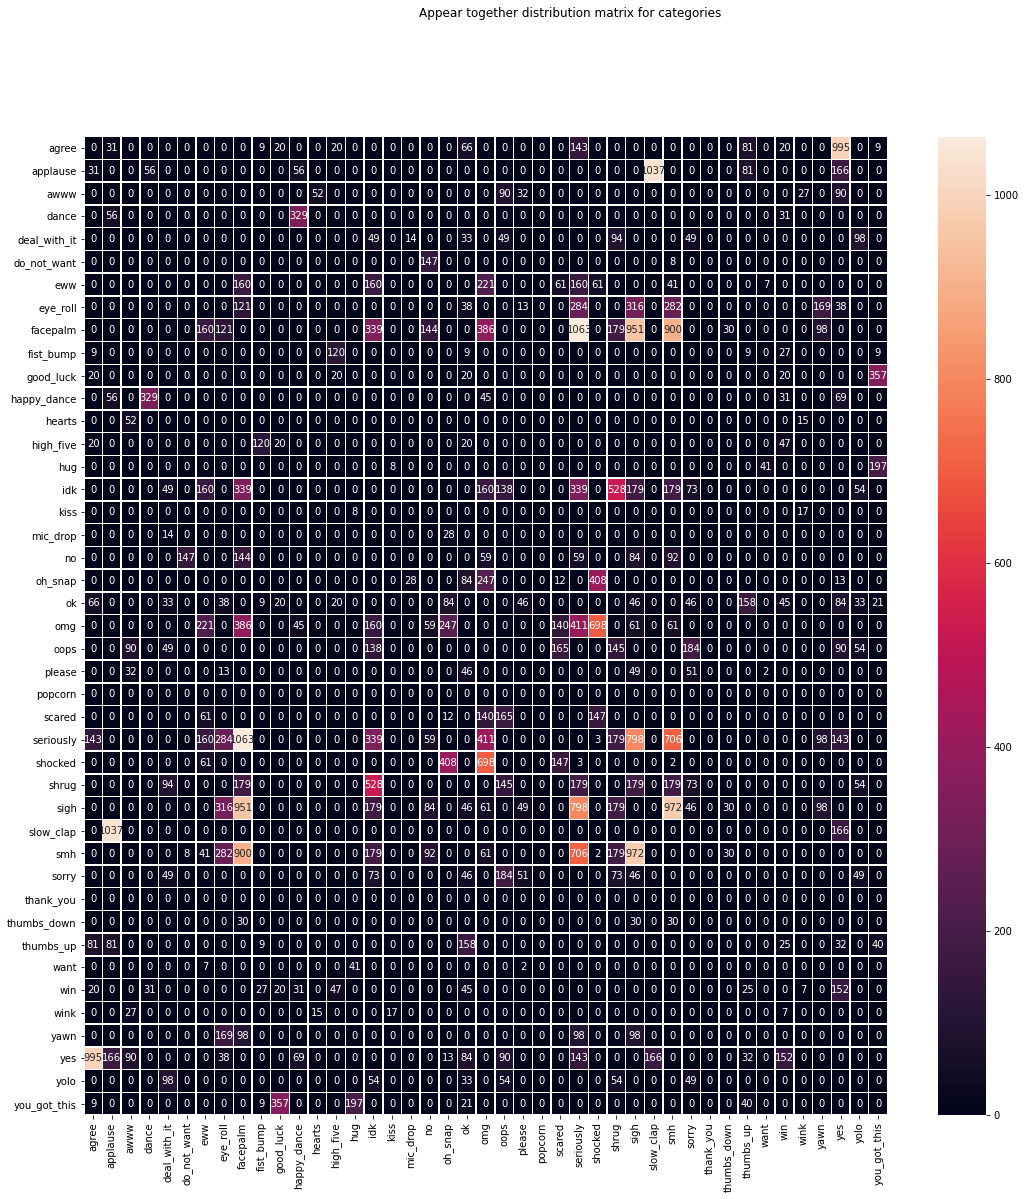

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(18, 18))
f.suptitle('Appear together distribution matrix for categories')
sns.heatmap(category_matrix, annot=True, linewidths=.5, ax=ax, fmt='d', xticklabels=categories_mapping.keys(), yticklabels=categories_mapping.keys())

# Part 2

## Majority Prediction

In [ ]:
df_dev = pd.read_json('dev_unlabeled.json', lines=True)

In [ ]:
most_6 = cat_count.most_common(6)
total_predict = []
for i in range(len(df_dev)):
  predict_list = []
  for cat, count in most_6:
    predict_list.append(cat)
  total_predict.append(predict_list)


In [ ]:
df_dev['categories'] = total_predict
df_dev.to_json('dev_majority_prediction.json', orient='records', lines=True)

## Naive Bayes

In [ ]:
vectorizer = TfidfVectorizer() # using default parameters
vectorizer.fit(train_data['text'])
train_X = vectorizer.transform(train_data['text'])
train_y = [categories[0] for categories in train_data['categories'].to_list()]
trans_train = []
for cat in train_y:
  trans_train.append(categories_mapping[cat])
clf = MultinomialNB()
clf.fit(train_X.toarray(), train_y)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [ ]:
df_dev = pd.read_json('dev_unlabeled.json', lines=True)

In [ ]:
dev_X = vectorizer.transform(df_dev['text'])

In [ ]:
probabilities = clf.predict_proba(dev_X.toarray())
total_predict = []
for row in probabilities:
    predict_class = []
    sort_index = sorted(range(len(row)), key=lambda k: row[k], reverse=True)
    for key, value in categories_mapping.items():
        if value in sort_index[0:6]:
            predict_class.append(key)
    total_predict.append(predict_class)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
df_dev['categories'] = total_predict
df_dev.to_json('dev_naive_bayes.json', orient='records', lines=True)

## check result

In [ ]:
test_X = vectorizer.transform(test_data['text'])

In [ ]:
probabilities = clf.predict_proba(test_X.toarray())
avg_map = 0
for eid, each_outputs in enumerate(probabilities):
    correct = 0
    sort_index = sorted(range(len(probabilities[eid])), key=lambda k: probabilities[eid][k], reverse=True)
    for key, value in categories_mapping.items():
        if value in sort_index[0:6]:
            if key in test_data['categories'][eid]:
                correct += 1
    avg_map += (correct / len(test_data['categories'][eid]))

avg_map /= len(test_data['categories'])
print("avg map = {}".format(avg_map))

avg map = 0.41976041666666686
